In [11]:
# Import relevant libraries
import os #computer stuff
import numpy as np
import matplotlib.pyplot as plt #plots
import pandas as pd #to work with datasets
from zipfile import ZipFile
import os

import mne
import mne_nirs

# Import StatsModels
import statsmodels.formula.api as smf
import tqdm


from mne_nirs.experimental_design import make_first_level_design_matrix #making design matrices
from mne_nirs.statistics import run_glm #making ocntrasts
from mne_nirs.statistics import statsmodels_to_results
from mne_nirs.visualisation import plot_glm_group_topo
from mne_nirs.visualisation import plot_glm_surface_projection
from mne_nirs.channels import (get_long_channels, 
                               get_short_channels,
                               picks_pair_to_idx) 
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from nilearn.plotting import plot_design_matrix #another project before mne nirs, they are using it for plotting design matrices

from itertools import compress #for loops, iterations in general
from icecream import ic #like "print"

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids, get_entity_vals

import matplotlib as mpl
from lets_plot import *
LetsPlot.setup_html()

from plotnine import ggplot, aes, geom_line, geom_point, facet_grid, geom_hline
import surfer

print('packages have been imported')

packages have been imported


That was painful. Remember to check that you are installing the packages into the specific python environment (might have to use the terminal outside of VSC). Here, I use Python 3.9.7. 
Continuing to the preprocessing.

First, we have some clever functions. 

- Normalize the data 
This function standardizes the data by use of the mean and the standard deviation.

- Preprocess
This function converts the raw intensity to optical density, which is then corrected by use of short channel regression. Motion correction is then performed by use of the TDDR method. The modified Beer-Lambert law is then applied to the data to get oxy- and deoxy levels of the data. Data is then further cleaned by use of a signal enhancement function (?).

Note! Here we are NOT applying the SCI (scalp-coupling index), which could have been helpful.. We are also NOT applying a bandpass filter. 

- Individual analysis
Here, we input the channels which we are interested in (source-detector pairs) and the contrasts, which we will perform the analysis on. The data is then put through the preprocessing function before it is analysized using a GLM. 


QUESTIONS FOR ESBEN
- shouldn't we filter out the short-channels from the actual analysis? - ok we do that
    - why do we use the short-channels as a 'regressor' for the GLM? what does that mean? 
    - Design matrix, used when doing GLM, 
- Shouldn't we try to use SCI to determine which channels are 'bad'?
    - we have to determine good/bad channels in some way 
- shouldn't we apply a bandpass filter?
- when do we use the normalize function?
- walkthrough of the two group results chunks 
- walkthrough of the two plotting chunks (one doesn't work)
- ggplot doesnot' work (?)

In [65]:

def preprocess(raw_intensity, verbose=True):
    """
    Loads the raw data from the path and procesess it
    """
    # if verbose:
    #     ic("Loading ", path)
    # raw_intensity = mne.io.read_raw_snirf(raw_path, preload=True)
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

    #sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od, l_freq=0.7, h_freq=1.5)
    #raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.2))

    # if verbose:
    ic("Apply short channel regression.")
    od_corrected = mne_nirs.signal_enhancement.short_channel_regression(raw_od)

    if verbose:
        ic("Do temporal derivative distribution repair on:", od_corrected)
    tddr_od = mne.preprocessing.nirs.tddr(od_corrected)

    if verbose:
        ic("Convert to haemoglobin with the modified beer-lambert law.")
    raw_haemo = beer_lambert_law(tddr_od, ppf=0.1)

    if verbose:
        ic("Apply further data cleaning techniques and extract epochs.")
    raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(
        raw_haemo)

  
    # if verbose:
    #     ic("Bandpass filter on:", raw_haemo)
    filter_haemo = raw_haemo.filter(
        0.01, 0.7, h_trans_bandwidth=0.3, l_trans_bandwidth=0.005)


    return raw_haemo

def individual_analysis(bids_path, ID, roi_1, roi_2, contrasts_1, contrasts_2):

    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path)

    raw_haemo = preprocess(raw_intensity)

    # Cut out just the short channels for creating a GLM repressor
    sht_chans = get_short_channels(raw_haemo)
    raw_haemo = get_long_channels(raw_haemo)

    # Create a design matrix
    design_matrix = make_first_level_design_matrix(raw_haemo)

    # Append short channels mean to design matrix
    design_matrix["ShortHbO"] = np.mean(sht_chans.copy().pick(picks="hbo").get_data(), axis=0)
    design_matrix["ShortHbR"] = np.mean(sht_chans.copy().pick(picks="hbr").get_data(), axis=0)

    # Run GLM
    glm_est = run_glm(raw_haemo, design_matrix)

    # Define channels in each region of interest
    # List the channel pairs manually
    # Then generate the correct indices for each pair
    groups = dict(
        ROI_1=picks_pair_to_idx(raw_haemo, roi_1, on_missing='ignore'),
        ROI_2=picks_pair_to_idx(raw_haemo, roi_2, on_missing='ignore'))

    # Extract channel metrics
    cha = glm_est.to_dataframe()

    # Compute region of interest results from channel data
    roi = glm_est.to_dataframe_region_of_interest(groups,
                                                  design_matrix.columns,
                                                  demographic_info=True)

    # Define left vs right tapping contrast
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

    contrast_LvR = basic_conts[contrasts_1[0]]
    for idx, con in enumerate(contrasts_1):
        if idx != 0: contrast_LvR + basic_conts[con]
    for con in contrasts_2:
        contrast_LvR - basic_conts[con]
    
    # Compute defined contrast
    contrast = glm_est.compute_contrast(contrast_LvR)
    con = contrast.to_dataframe()

    # Add the participant ID to the dataframes
    roi["ID"] = cha["ID"] = con["ID"] = ID

    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.e6 for t in roi["theta"]]
    con["effect"] = [t * 1.e6 for t in con["effect"]]

    return raw_haemo, roi, cha, con


Next, we put in our information. That is, which files to preprocess, the regions of interest and contrasts. 
First, I try the analysis on a few files, to make sure the code runs. 
I test H1 (visual cortex).
Here, ROI 1 is visual and ROI 2 is auditory (maybe). 

In [76]:
df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results
df_con = pd.DataFrame()  # To store channel level contrast results

subjects_test = [
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-305-2021-11-01/2021-11-01_003.snirf"
]

# 21 subjects
subjects = [
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-305-2021-11-01/2021-11-01_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-124-2021-11-04/2021-11-04_004.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-200-2021-11-04/2021-11-04_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-201-2021-11-04/2021-11-04_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-306-2021-11-04/2021-11-04_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-118-2021-11-08/2021-11-08_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-129-2021-11-08/2021-11-08_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-400-2021-11-08/2021-11-08_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-119-2021-11-11/2021-11-11_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-123-2021-11-11/2021-11-11_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-402-2021-11-11/2021-11-11_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-203-2021-11-15/2021-11-15_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-204-2021-11-15/2021-11-15_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-300-2021-11-15/2021-11-15_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-112-2021-10-14/2021-10-14_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-122-2021-10-21/2021-10-21_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-125-2021-10-21/2021-10-21_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-206-2021-11-18/2021-11-18_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-302-2021-10-28/2021-10-28_002.snirf"
]

for idx, sub in enumerate(subjects):
    # Analyse data and return both ROI and channel results
    raw_haemo, roi, channel, con = individual_analysis(
        sub, idx, 
        roi_1=[[15,14], [15,12], [15,11], [16,14], [16,13], [16,16], [16,15], [31,15], [31,16],[31,30], [29,13], [29,16], [29,28], [30,16], [30,28], [30,30], [30,29], [32,30], [32,29], [32,27], [14,11], [14,14], [14,13], [27,28], [27,29], [27,26]
        ], # visual
        roi_2=[[11,10], [11,8], [11,9], [9,6], [9,10], [9,8], [7,6], [7,8], [7,5],[10,8], [10,5], [10,9], [10,7], [8,5], [8,7], [12,7], [12,9], [21,20], [21,22], [25,22], [25,24], [23,22], [23,20], [23,24], [23,23], [22,20], [22,23], [22,21], [26,24], [26,23], [26,25], [24,21], [24,23], [24,25]
        ], #auditory 
        contrasts_1=['70', '71', '72'], contrasts_2=['61', '62', '63'])

    # Append individual results to all participants
    df_roi = df_roi.append(roi)
    df_cha = df_cha.append(channel)
    df_con = df_con.append(con)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf
Reading 0 ... 8022  =      0.000 ...  2102.566 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-01_001.snirf, 232 x 8023 (2102.6 s), ~14.5 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf
Reading 0 ... 6905  =      0.000 ...  1809.800 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-01_002.snirf, 232 x 6906 (1809.8 s), ~12.6 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-305-2021-11-01/2021-11-01_003.snirf
Reading 0 ... 7746  =      0.000 ...  2030.227 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-01_003.snirf, 232 x 7747 (2030.2 s), ~14.0 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-124-2021-11-04/2021-11-04_004.snirf
Reading 0 ... 8929  =      0.000 ...  2340.291 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-04_004.snirf, 232 x 8930 (2340.3 s), ~16.1 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-200-2021-11-04/2021-11-04_003.snirf
Reading 0 ... 8456  =      0.000 ...  2216.318 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-04_003.snirf, 232 x 8457 (2216.3 s), ~15.3 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-201-2021-11-04/2021-11-04_002.snirf
Reading 0 ... 7991  =      0.000 ...  2094.441 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-04_002.snirf, 232 x 7992 (2094.4 s), ~14.5 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-306-2021-11-04/2021-11-04_001.snirf
Reading 0 ... 7842  =      0.000 ...  2055.388 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-04_001.snirf, 232 x 7843 (2055.4 s), ~14.2 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-118-2021-11-08/2021-11-08_003.snirf
Reading 0 ... 8820  =      0.000 ...  2311.722 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-08_003.snirf, 232 x 8821 (2311.7 s), ~15.9 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-129-2021-11-08/2021-11-08_001.snirf
Reading 0 ... 8319  =      0.000 ...  2180.410 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-08_001.snirf, 232 x 8320 (2180.4 s), ~15.1 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-400-2021-11-08/2021-11-08_002.snirf
Reading 0 ... 7773  =      0.000 ...  2037.303 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-08_002.snirf, 232 x 7774 (2037.3 s), ~14.1 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-119-2021-11-11/2021-11-11_001.snirf
Reading 0 ... 7676  =      0.000 ...  2011.880 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-11_001.snirf, 232 x 7677 (2011.9 s), ~13.9 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-123-2021-11-11/2021-11-11_001.snirf
Reading 0 ... 7197  =      0.000 ...  1886.334 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-11_001.snirf, 232 x 7198 (1886.3 s), ~13.1 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-402-2021-11-11/2021-11-11_002.snirf
Reading 0 ... 7395  =      0.000 ...  1938.229 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-11_002.snirf, 232 x 7396 (1938.2 s), ~13.4 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-203-2021-11-15/2021-11-15_002.snirf
Reading 0 ... 10258  =      0.000 ...  2688.622 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-15_002.snirf, 232 x 10259 (2688.6 s), ~18.5 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-204-2021-11-15/2021-11-15_003.snirf
Reading 0 ... 8065  =      0.000 ...  2113.836 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-15_003.snirf, 232 x 8066 (2113.8 s), ~14.6 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-300-2021-11-15/2021-11-15_001.snirf
Reading 0 ... 8045  =      0.000 ...  2108.595 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-15_001.snirf, 232 x 8046 (2108.6 s), ~14.6 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-112-2021-10-14/2021-10-14_002.snirf
Reading 0 ... 6919  =      0.000 ...  1813.470 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-10-14_002.snirf, 232 x 6920 (1813.5 s), ~12.6 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-122-2021-10-21/2021-10-21_002.snirf
Reading 0 ... 8617  =      0.000 ...  2258.516 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-10-21_002.snirf, 232 x 8618 (2258.5 s), ~15.6 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-125-2021-10-21/2021-10-21_002.snirf
Reading 0 ... 8203  =      0.000 ...  2150.006 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-10-21_002.snirf, 232 x 8204 (2150.0 s), ~14.8 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-206-2021-11-18/2021-11-18_001.snirf
Reading 0 ... 7256  =      0.000 ...  1901.798 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-18_001.snirf, 232 x 7257 (1901.8 s), ~13.2 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-302-2021-10-28/2021-10-28_002.snirf
Reading 0 ... 10537  =      0.000 ...  2761.748 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-10-28_002.snirf, 232 x 10538 (2761.7 s), ~19.0 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 2519 samples (660.230 sec)



To the good part - group results

,ROI,Condition,Chroma,theta,se,t,dfe,p,ID
0,ROI_1,61,hbo,-11.600645,6.436365,-1.802360,82.0,0.075163,0
2,ROI_2,61,hbo,-3.510488,7.244134,-0.484597,82.0,0.629254,0
0,ROI_1,62,hbo,-1.192980,6.248944,-0.190909,82.0,0.849069,0
2,ROI_2,62,hbo,-2.991587,7.045372,-0.424617,82.0,0.672228,0
0,ROI_1,63,hbo,2.252770,6.177962,0.364646,82.0,0.716314,0
...,...,...,...,...,...,...,...,...,...
2,ROI_2,70,hbo,-4.750190,7.179276,-0.661653,95.0,0.509795,20
0,ROI_1,71,hbo,-2.655876,6.740974,-0.393990,95.0,0.694471,20
2,ROI_2,71,hbo,-19.624919,7.198790,-2.726142,95.0,0.007631,20
0,ROI_1,72,hbo,0.043933,6.721393,0.006536,95.0,0.994798,20


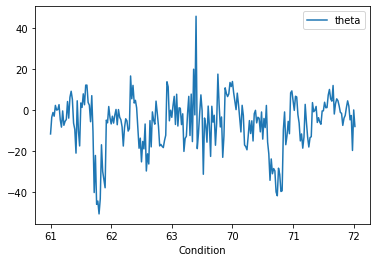

In [77]:
grp_results = df_roi.query("Condition in ['70', '71', '72', '61', '62', '63']")
grp_results = grp_results.query("Chroma in ['hbo']")

grp_results.plot(x = "Condition", y = "theta")

grp_results

Modelling time


In [78]:
grp_results = df_roi.query("Condition in ['70', '71', '72', '61', '62', '63']")

#making a new column
grp_results["Visual_auditory"] = np.where(grp_results.Condition.isin(['70', '71', '72']), "Visual", "Auditory")
grp_results.head()

#model
roi_model = smf.mixedlm("theta ~ -1 + ROI:Visual_auditory:Chroma",
                        grp_results, groups=grp_results["ID"]).fit(method='nm')
roi_model.summary()
#grp_results

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_99421/2889942713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
============================================================================================
Model:                        MixedLM             Dependent Variable:             theta     
No. Observations:             504                 Method:                         REML      
No. Groups:                   21                  Scale:                          93.7072   
Min. group size:              24                  Log-Likelihood:                 -1854.9605
Max. group size:              24                  Converged:                      Yes       
Mean group size:              24.0                                                          
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------
ROI[ROI_1]:Visual_auditory[Auditory]:Chroma[hbo] -6.613    1.320 -5.010 0.000  -9.200 -4.026
ROI[ROI_2]:Visual_auditory[Auditory]:Chroma[hbo] -6.007    1.320 -4.551 0.000  -8.594 -3.420
ROI[ROI_1]:Visual_auditory[Visual]:Chroma[hbo]   -3.315    1.320 -2.512 0.012  -5.902 -0.728
ROI[ROI_2]:Visual_auditory[Visual]:Chroma[hbo]   -9.244    1.320 -7.003 0.000 -11.831 -6.657
ROI[ROI_1]:Visual_auditory[Auditory]:Chroma[hbr]  2.323    1.320  1.760 0.078  -0.264  4.910
ROI[ROI_2]:Visual_auditory[Auditory]:Chroma[hbr]  2.912    1.320  2.206 0.027   0.325  5.499
ROI[ROI_1]:Visual_auditory[Visual]:Chroma[hbr]    1.292    1.320  0.978 0.328  -1.295  3.879
ROI[ROI_2]:Visual_auditory[Visual]:Chroma[hbr]    4.461    1.320  3.380 0.001   1.874  7.049
Group Var                                         5.351    0.309                            
============================================================================================

"""

In [79]:
grp_results.to_csv("group_results.csv")

Plotting time

<AxesSubplot:title={'center':'Contrast'}>

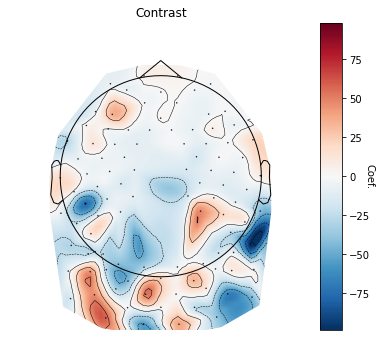

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
con_summary = df_con.query("Chroma in ['hbo']")

# Run group level model and convert to dataframe
con_model = smf.mixedlm("effect ~ -1 + ch_name:Chroma",
                        con_summary, groups=con_summary["ID"]).fit(method='nm')
con_model_df = statsmodels_to_results(con_model,
                                      order=raw_haemo.copy().pick(
                                          picks="hbo").ch_names)

#con_model_df['Coef.'] = -con_model_df['Coef.']

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    con_model_df, colorbar=True, axes=axes)

Kommentar til resultater:
- hvorfor er der aktivering i områder ud over de ROIs jeg har angivet?


trying out ROI plot

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),
                         gridspec_kw=dict(width_ratios=[1, 1]))

# Cut down the dataframe just to the conditions we are interested in
con_summary = df_con.query("Chroma in ['hbo']")

# Run group level model and convert to dataframe
con_model = smf.mixedlm("effect ~ -1 + ch_name:Chroma",
                        con_summary, groups=con_summary["ID"]).fit(method='nm')
con_model_df = statsmodels_to_results(con_model,
                                      order=raw_haemo.copy().pick(
                                          picks="hbo").ch_names)


# Plot the two conditions
plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    ch_model_df.query("Condition in ['70', '71', '72', '61', '62', '63']"),
                    colorbar=False, axes=axes[0, 0],
                    vmin=0, vmax=20, cmap=mpl.cm.Oranges)

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    ch_model_df.query("Condition in ['Tapping/Right']"),
                    colorbar=True, axes=axes[0, 1],
                    vmin=0, vmax=20, cmap=mpl.cm.Oranges)


ValueError: Expected the given number of width ratios to match the number of columns of the grid

<Figure size 720x720 with 0 Axes>

2D mapping - virker ikke

In [70]:
# Generate brain figure from data
clim = dict(kind='value', pos_lims=(0, 8, 11))
brain = plot_glm_surface_projection(raw_haemo.copy().pick("hbo"),
                                    con_model_df, clim=clim, view='dorsal',
                                    colorbar=True, size=(800, 700))
brain.add_text(0.05, 0.95, "Left-Right", 'title', font_size=16, color='k')

# Run model code as above
clim = dict(kind='value', pos_lims=(0, 11.5, 17))
for idx, cond in enumerate(['76', '78']):

    # Run same model as explained in the sections above
    ch_summary = df_cha.query("Condition in [@cond]")
    ch_summary = ch_summary.query("Chroma in ['hbo']")
    ch_model = smf.mixedlm("theta ~ -1 + ch_name", ch_summary,
                           groups=ch_summary["ID"]).fit(method='nm')
    model_df = statsmodels_to_results(ch_model, order=raw_haemo.copy().pick("hbo").ch_names)

    # Generate brain figure from data
    brain = plot_glm_surface_projection(raw_haemo.copy().pick("hbo"),
                                        model_df, clim=clim, view='dorsal',
                                        colorbar=True, size=(800, 700))
    brain.add_text(0.05, 0.95, cond, 'title', font_size=16, color='k')

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_99421/541132561.py:3: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead
/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_99421/541132561.py:3: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead
/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_99421/541132561.py:3: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead


ImportError: cannot import name 'Brain' from 'surfer' (/Users/sigridagersnapbomnielsen/opt/anaconda3/lib/python3.9/site-packages/surfer/__init__.py)

# Regenerate the results from the original group model above
grp_results = df_roi.query("Condition in ['Control','Tapping/Left', 'Tapping/Right']")
roi_model = smf.mixedlm("theta ~ -1 + ROI:Condition:Chroma",
                        grp_results, groups=grp_results["ID"]).fit(method='nm')

df = statsmodels_to_results(roi_model)

ggplot(df.query("Chroma == 'hbo'"),
       aes(x='Condition', y='Coef.', color='Significant', shape='ROI')) \
    + geom_hline(y_intercept=0, linetype="dashed", size=1) \
    + geom_point(size=5) \
    + scale_shape_manual(values=[16, 17]) \
    + ggsize(900, 300) \
    + geom_point(data=df.query("Chroma == 'hbr'")
                 .query("ROI == 'Left_Hemisphere'"), size=5, shape=1) \
    + geom_point(data=df.query("Chroma == 'hbr'")
                 .query("ROI == 'Right_Hemisphere'"), size=5, shape=2)

something else

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf
Reading 0 ... 8022  =      0.000 ...  2102.566 secs...


ic| 'Apply short channel regression.'
ic| "Do temporal derivative distribution repair on:": 'Do temporal derivative distribution repair on:'
    od_corrected: <RawSNIRF | 2021-11-01_001.snirf, 232 x 8023 (2102.6 s), ~14.5 MB, data loaded>
ic| 'Convert to haemoglobin with the modified beer-lambert law.'
ic| 'Apply further data cleaning techniques and extract epochs.'
/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_99421/4262721289.py:5: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.


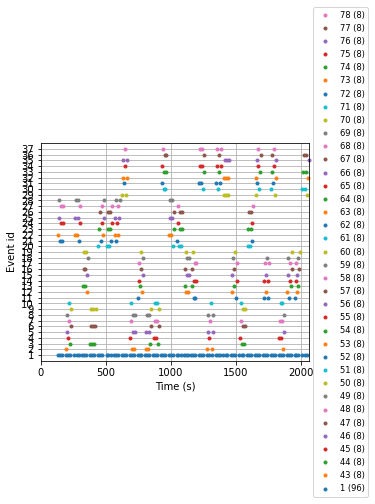

Used Annotations descriptions: ['1', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78']


Text(0.5, 0, 'Time (s)')

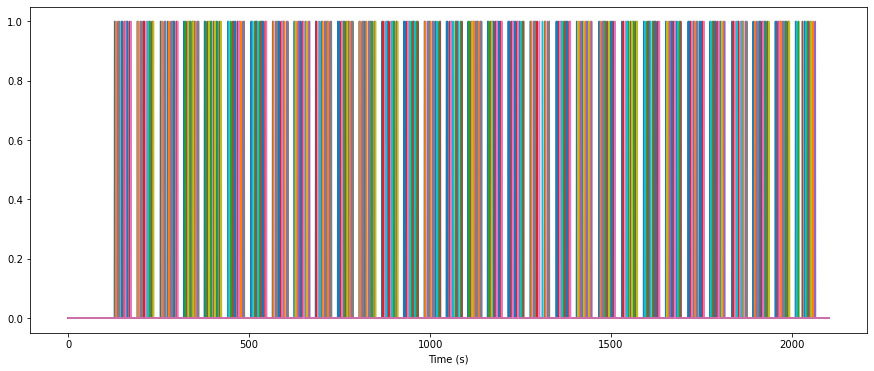

In [19]:
raw_path = "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf"

raw_haemo = preprocess(mne.io.read_raw_snirf(raw_path))
events, event_dict = mne.events_from_annotations(raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info['sfreq'])

s = mne_nirs.experimental_design.create_boxcar(raw_haemo)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plt.plot(raw_haemo.times, s, axes=axes)
plt.xlabel("Time (s)")

Trying to the cool Hbo Hbr plot



In [75]:
help(raw_haemo)

Help on RawSNIRF in module mne.io.snirf._snirf object:

class RawSNIRF(mne.io.base.BaseRaw)
 |  RawSNIRF(fname, optode_frame='unknown', preload=False, verbose=None)
 |  
 |  Raw object from a continuous wave SNIRF file.
 |  
 |  Parameters
 |  ----------
 |  fname : str
 |      Path to the SNIRF data file.
 |  optode_frame : str
 |      Coordinate frame used for the optode positions. The default is unknown,
 |      in which case the positions are not modified. If a known coordinate
 |      frame is provided (head, meg, mri), then the positions are transformed
 |      in to the Neuromag head coordinate frame (head).
 |  
 |  preload : bool or str (default False)
 |      Preload data into memory for data manipulation and faster indexing.
 |      If True, the data will be preloaded into memory (fast, requires
 |      large amount of memory). If preload is a string, preload is the
 |      file name of a memory-mapped file which is used to store the data
 |      on the hard drive (slower, r

In [71]:
evoked_dict = {'Visual/HbO': epochs['70, 71, 72'].average(picks='hbo'),
               'Visual/HbR': epochs['70, 71, 72'].average(picks='hbr'),
               'Auditory/HbO': epochs['61, 62, 63'].average(picks='hbo'),
               'Auditory/HbR': epochs['61, 62, 63'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict, styles=styles_dict)

NameError: name 'epochs' is not defined